# Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


In [2]:
sns.set(rc={'figure.figsize':(16, 8)})
#sns.set(font_scale=2)
sns.set_style("whitegrid")

# Data sets

Several datasets together contain information about the user funnel on the site:   
   
    home_page_table.csv
    search_page_table.csv
    payment_page_table.csv
    payment_confirmation_table.csv
    
And there is also a separate table with users:

    user_table.csv

In [10]:
home = pd.read_csv('funnel/home_page_table.csv')
print(home.shape, f'Unique user_id = {home["user_id"].nunique()}')
home.head()

(90400, 2) Unique user_id = 90400


,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [6]:
search = pd.read_csv('funnel/search_page_table.csv')
print(search.shape, f'Unique user_id = {search["user_id"].nunique()}')
search.head()
                

(45200, 2) Unique user_id = 45200


,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [7]:
payment_page = pd.read_csv('funnel/payment_page_table.csv')
print(payment_page.shape, f'Unique user_id = {payment_page["user_id"].nunique()}')
payment_page.head()

(6030, 2) Unique user_id = 6030


,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [8]:
payment_confirmation = pd.read_csv('funnel/payment_confirmation_table.csv')
print(payment_confirmation.shape, f'Unique user_id = {payment_confirmation["user_id"].nunique()}')
payment_confirmation.head()

(452, 2) Unique user_id = 452


,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


In [16]:
users = pd.read_csv('funnel/user_table.csv')
print(users.shape, f'Unique user_id = {users["user_id"].nunique()}, unique dates = {users["date"].nunique()}')
print(f'min date = {users["date"].min()}, max date = {users["date"].max()}')
users.head()

(90400, 4) Unique user_id = 90400, unique dates = 120
min date = 2015-01-01, max date = 2015-04-30


,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [23]:
# join all the data sets on user_id
df = users.merge(home, how='left', on='user_id').rename(columns={'page':'home'})
df = df.merge(search, how='left', on='user_id').rename(columns={'page':'search'})
df = df.merge(payment_page, how='left', on='user_id').rename(columns={'page':'payment_page'})
df = df.merge(payment_confirmation, how='left', on='user_id').rename(columns={'page':'payment_confirmation'})

# Aggregation

In [32]:
# aggregation by date and device

df_agg = df.groupby(['date','device'], as_index=False).agg({'home':'count',
                                                           'search':'count',
                                                           'payment_page':'count',
                                                           'payment_confirmation':'count'})

df_agg

,date,device,home,search,payment_page,payment_confirmation
0,2015-01-01,Desktop,493,256,47,1
1,2015-01-01,Mobile,219,180,29,5
2,2015-01-02,Desktop,484,261,44,1
3,2015-01-02,Mobile,237,186,40,4
4,2015-01-03,Desktop,507,222,22,3
...,...,...,...,...,...,...
235,2015-04-28,Mobile,260,54,16,1
236,2015-04-29,Desktop,453,219,4,0
237,2015-04-29,Mobile,260,52,6,0
238,2015-04-30,Desktop,538,274,10,0


In [87]:
df_agg['date'] = pd.to_datetime(df_agg['date'])
columns

Index(['C1', 'C2', 'C3'], dtype='object')

# First introduce, plotting

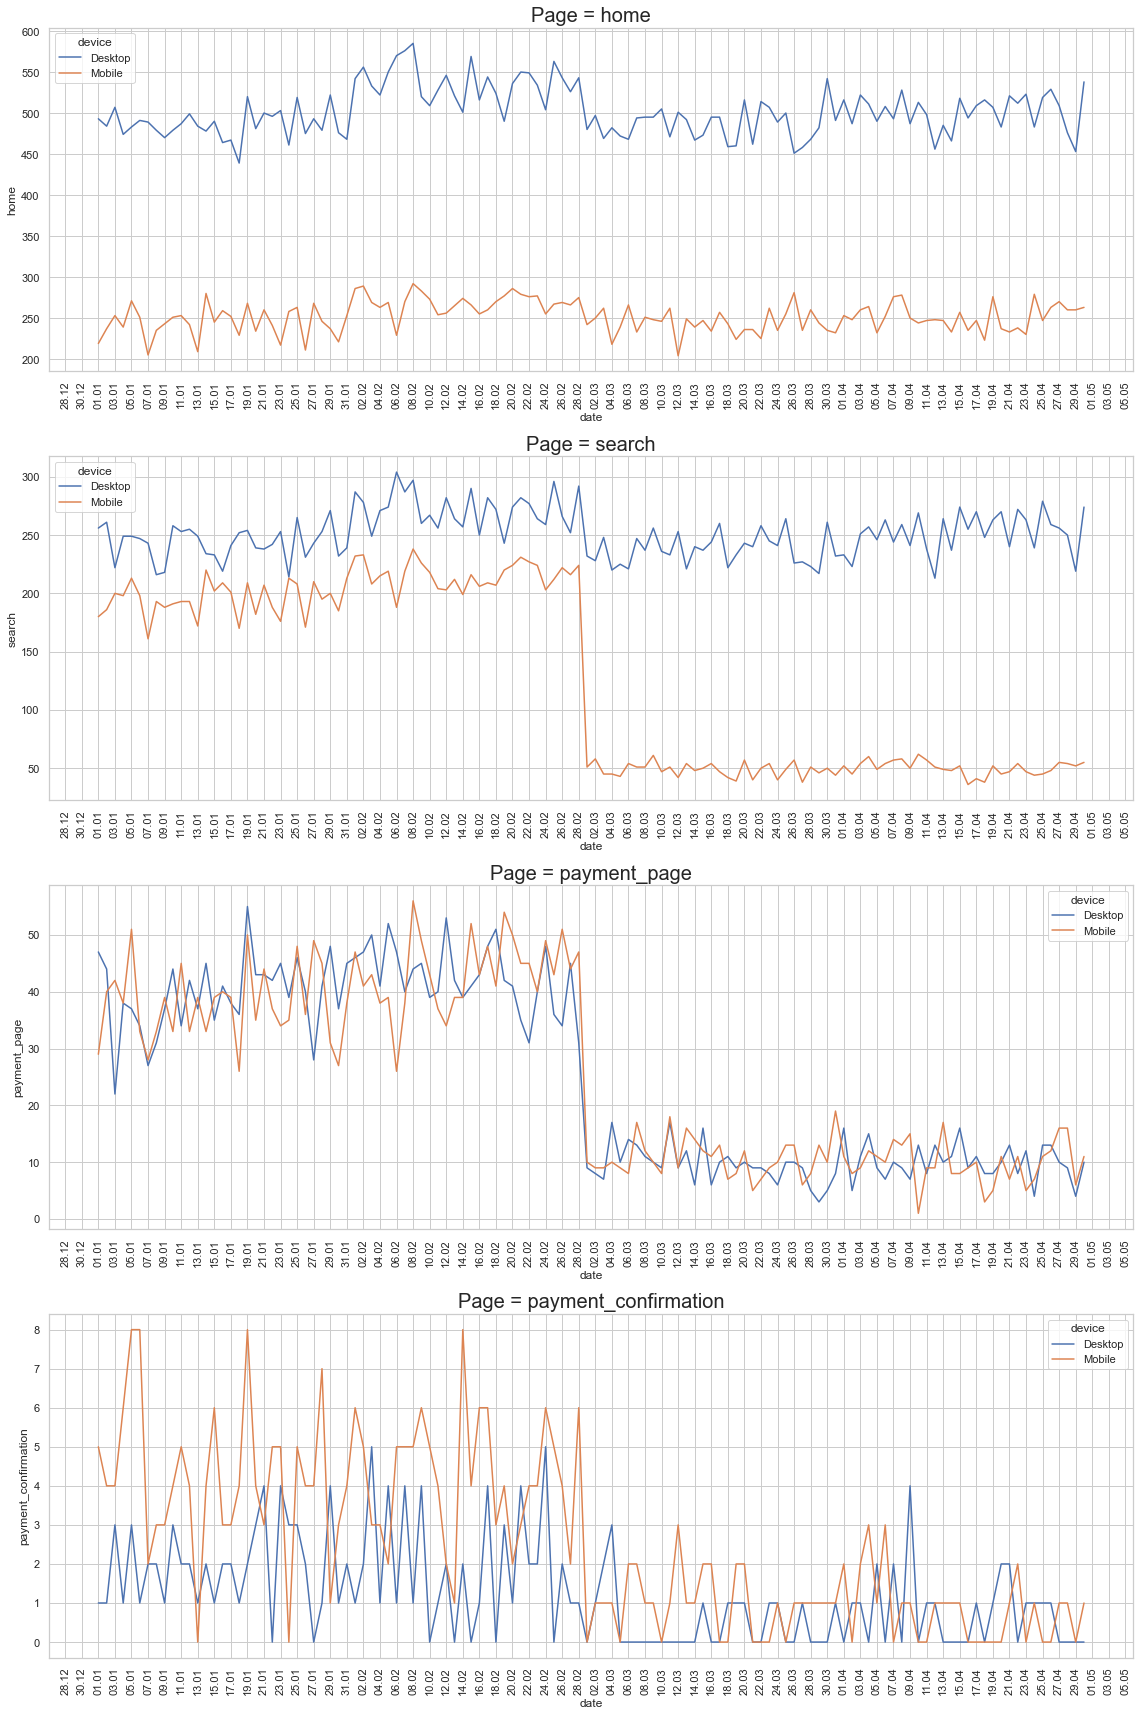

In [36]:
fig, ax = plt.subplots(4,1,figsize=(16,24))

columns = df_agg.columns[2:]

for i, ax in enumerate(ax.flatten()):
    
    g = sns.lineplot(data=df_agg, x='date', y=columns[i], hue='device', ax=ax)
    g.set_title(f"Page = {columns[i]}", fontsize=20)
    
    ax.xaxis.set_major_formatter(DateFormatter("%d.%m"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.tick_params(axis='x', labelrotation=90)
    
plt.tight_layout()

It is obvious that the desktop version of the application is more popular.

There is no global change in the picture on the **home page**, there are point anomalies, which, in principle, can be a variant of the norm, since there are not very many clients in general. The assessment of the anomaly of these outliers depends on the context of the business.

01.03.2015  there was some kind of failure on the **search and payment pages**, and on the search pages only have mobile clients were affected.

На страницах Search  и Payment Page 1 марта произошел какой-то сбой. Причем на  Search этот сбой прошел только для Mobile devices, на на странице Payment Page изменения затронуи уже оба вида devices, т.е. для Mobile devices это коллективная аномалия, для 

**Payment confirmation**  a lot of point anomolies (for example, on January 22 and January 27, when the number of payments fell to zero.) But there is little data and the number of payments per day is also small, it is quite possible that the absence of payments in general per day is a variant of the norm. In this case, you need to catch a contextual anomaly when the absence of payments lasts more than 1 day (for example, from 05.03 to 14.03)

# Define metrics to monitor

To understand and track at what level of the funnel a failure occurred, you will track the number of leads on the home page, and then monitor the conversion at each stage.


In [38]:
# calculate conversion, %
df_agg['C1'] = df_agg['search'] / df_agg['home'] *100
df_agg['C2'] = df_agg['payment_page'] / df_agg['search'] *100
df_agg['C3'] = df_agg['payment_confirmation'] / df_agg['payment_page'] *100

In [39]:
#df_agg

,date,device,home,search,payment_page,payment_confirmation,C1,C2,C3
0,2015-01-01,Desktop,493,256,47,1,51.926978,18.359375,2.127660
1,2015-01-01,Mobile,219,180,29,5,82.191781,16.111111,17.241379
2,2015-01-02,Desktop,484,261,44,1,53.925620,16.858238,2.272727
3,2015-01-02,Mobile,237,186,40,4,78.481013,21.505376,10.000000
4,2015-01-03,Desktop,507,222,22,3,43.786982,9.909910,13.636364
...,...,...,...,...,...,...,...,...,...
235,2015-04-28,Mobile,260,54,16,1,20.769231,29.629630,6.250000
236,2015-04-29,Desktop,453,219,4,0,48.344371,1.826484,0.000000
237,2015-04-29,Mobile,260,52,6,0,20.000000,11.538462,0.000000
238,2015-04-30,Desktop,538,274,10,0,50.929368,3.649635,0.000000


Let's see , what the metrics look like. 

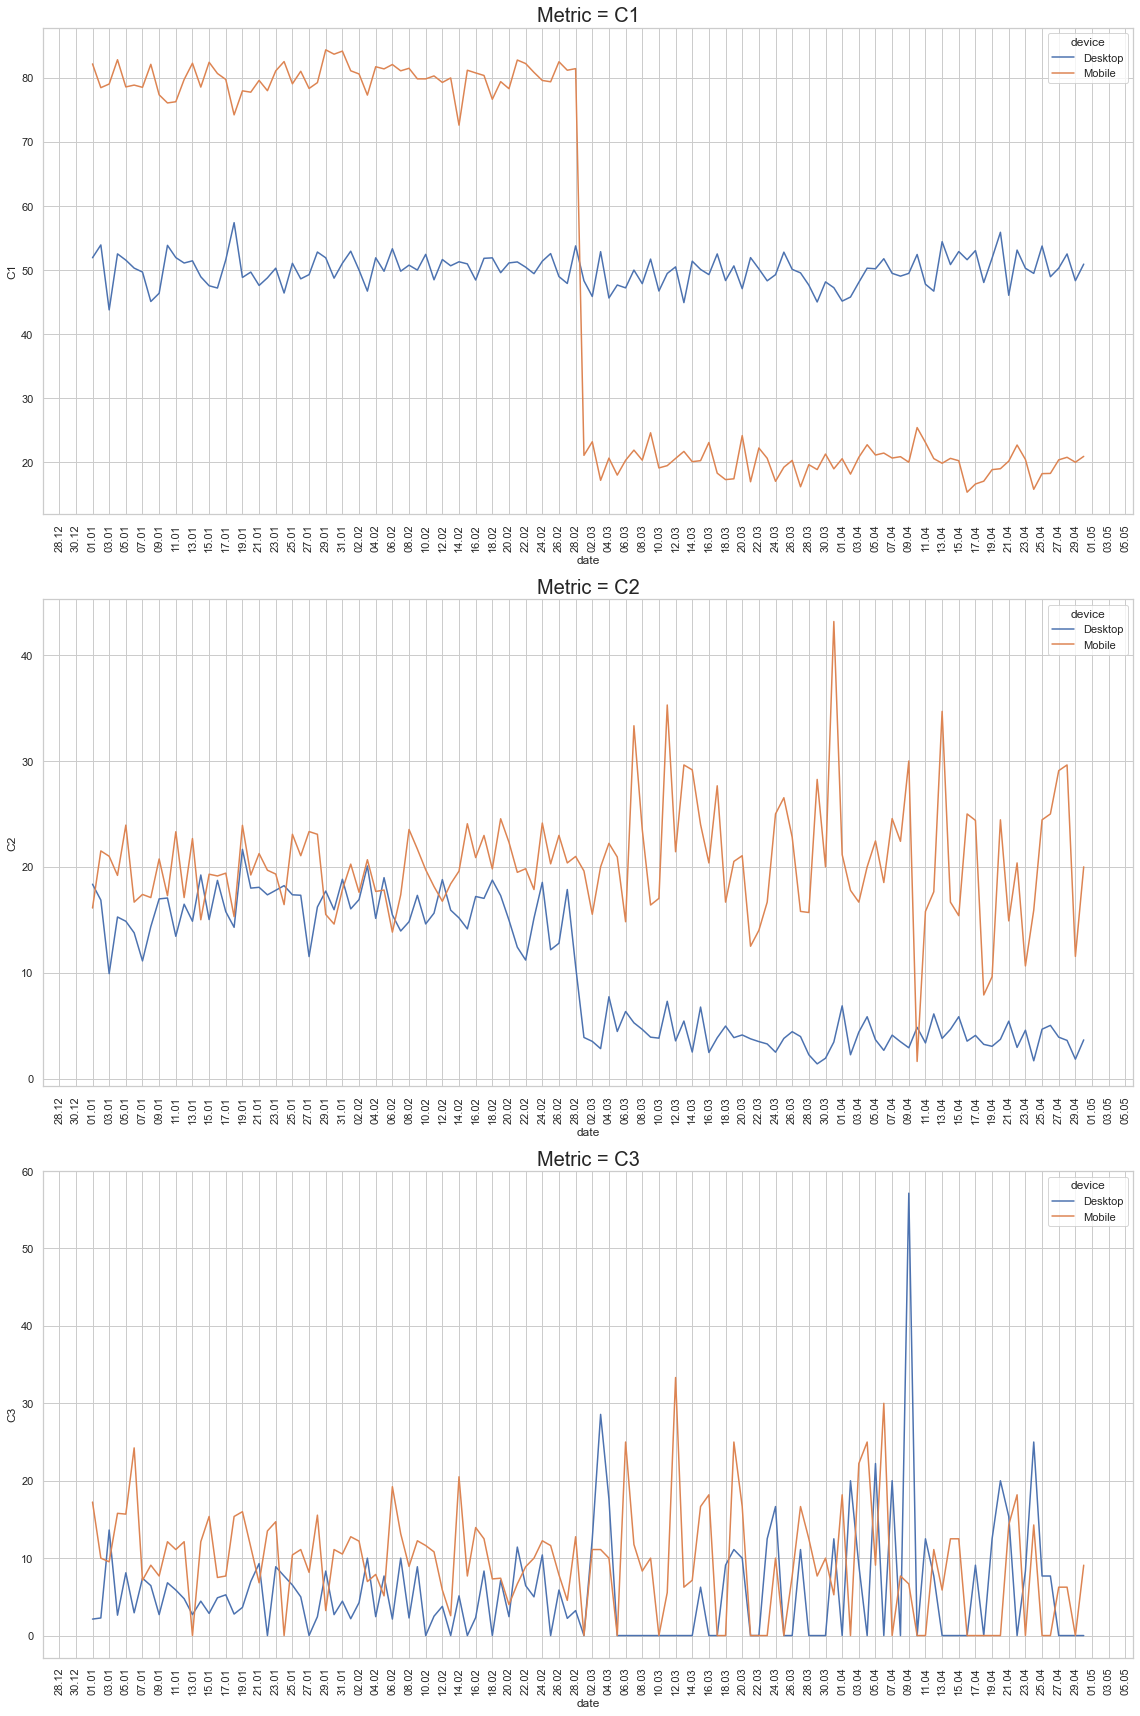

In [42]:
fig, ax = plt.subplots(3,1,figsize=(16,24))

columns = df_agg.columns[-3:]

for i, ax in enumerate(ax.flatten()):
    
    g = sns.lineplot(data=df_agg, x='date', y=columns[i], hue='device', ax=ax)
    g.set_title(f"Metric = {columns[i]}", fontsize=20)
    
    ax.xaxis.set_major_formatter(DateFormatter("%d.%m"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.tick_params(axis='x', labelrotation=90)
    
plt.tight_layout()
    

Interestingly, the conversion from mobile users is higher than from desktop ones.

Then a failure on the home page and reduction of leads will not become an alert on the other levels, i.e. our alert will allow us to understand exactly at what level the problem occurred.

#  Model

Seasonality, peaks and trend of the theoretical series at different levels of the funnel should coincide, so let's try to find a model that is good at detecting anomalies on the home page. Then we can try to use the same model to detect anomalies on the lower levels.

# seasonal_decompose

Let's decompose into seasonal components. 

The idea of detection is that the residual error after decomposition into components should be distributed normally and all emissions are immediately visible and we can determine the cutoff threshold ourselves.

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [48]:
result_decomp = seasonal_decompose(x=df_agg.loc[df_agg['device']=='Mobile','home'], model='additive', filt=None, period=7, two_sided=False, extrapolate_trend=0)

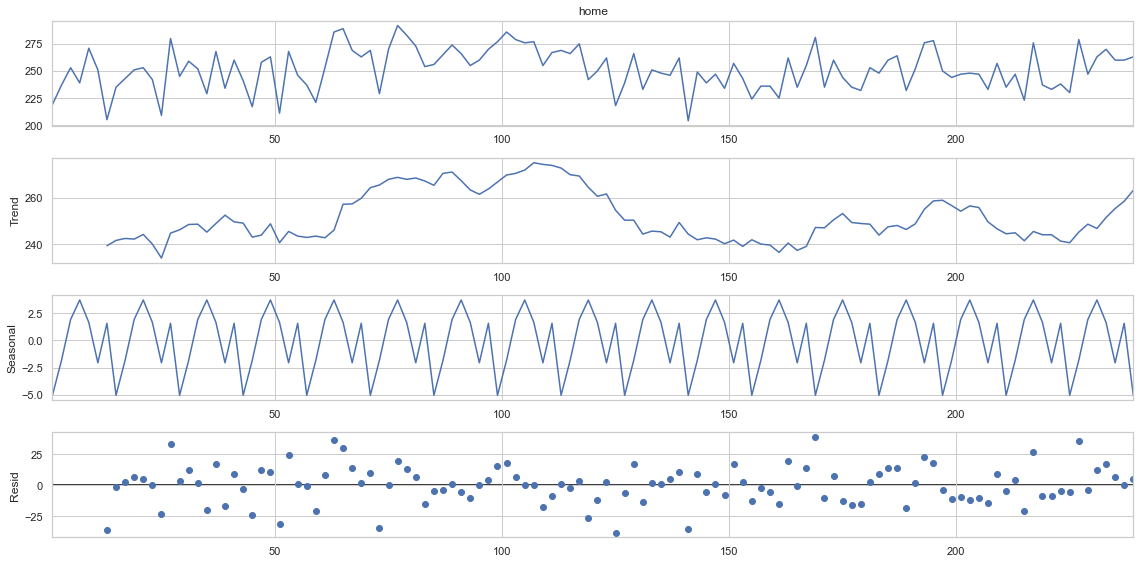

In [49]:
result_decomp.plot();

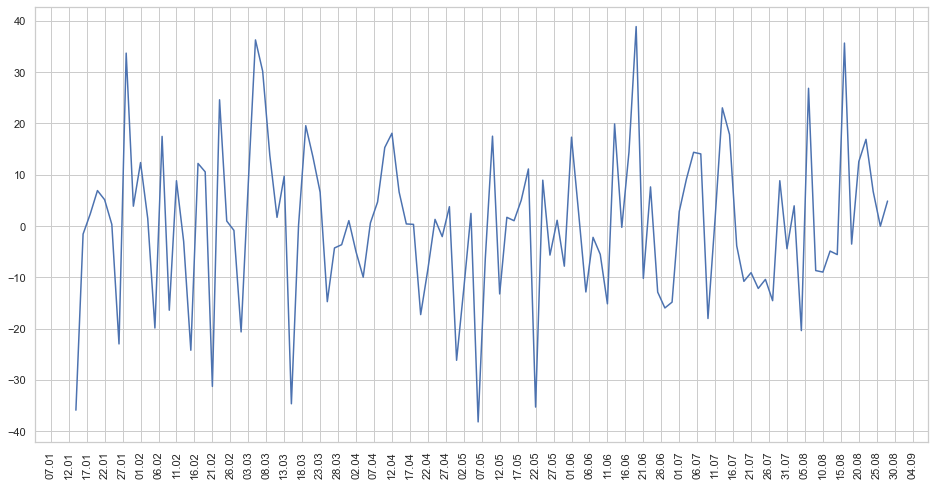

In [97]:
fig, ax = plt.subplots()

result_decomp.resid.plot()

ax.xaxis.set_major_formatter(DateFormatter("%d.%m"))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.tick_params(axis='x', labelrotation=90)

<AxesSubplot:>

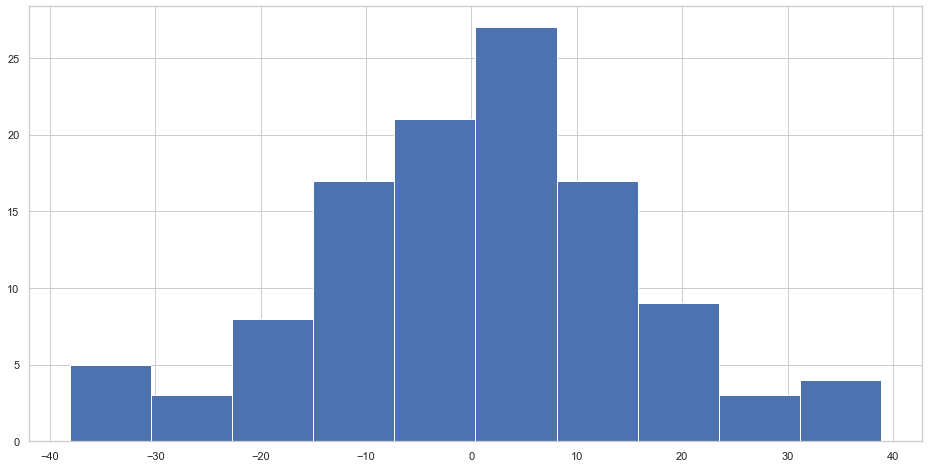

In [51]:
result_decomp.resid.hist()

## Simulation

This method catches sharp fluctuations in the series, whether it makes sense in this case - depends on the specifics of the business. 

Let's make a simulation of real monitoring. We will take the data from January to February as normal and check each new day for anomalies.

### Funktion

In [86]:
data_range  = pd.date_range(start='2015-02-28', periods=30, freq='D')
end = data_range[0]
end
df_test = df_agg[df_agg['device']=='Mobile'].set_index('date')

df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  240 non-null    object 
 1   device                240 non-null    object 
 2   home                  240 non-null    int64  
 3   search                240 non-null    int64  
 4   payment_page          240 non-null    int64  
 5   payment_confirmation  240 non-null    int64  
 6   C1                    240 non-null    float64
 7   C2                    240 non-null    float64
 8   C3                    240 non-null    float64
dtypes: float64(3), int64(4), object(2)
memory usage: 17.0+ KB


In [94]:
def detection_anomaly(df, device, metric, cutoff, periods, q_low= 0.01, q_high=0.997):
    
    data = df[df['device']==device].set_index('date').copy()
    
    # create a date range in which we will run the simulation
    data_range  = pd.date_range(start=cutoff, periods=periods, freq='D')
    
    # create a list without alerts for the base historical period 
    alert_list = [False for i in range(len(data[:cutoff][metric]))]
    
    for date in data_range:
        # calculate a residual for the base period and its quartiles
        result_decomp = seasonal_decompose(x=data[:date][metric], model='additive', period=7, two_sided=False)
        bound_low =  result_decomp.resid.quantile(q_low)
        bound_high = result_decomp.resid.quantile(q_high)
        #print(date, bound_low, bound_high)
        
        # 1 day shift for 'today' simulation 
        control_date = date + pd.Timedelta('1 day')
        
        #calculate a resudial for new period (included 'today')
        result_decomp = seasonal_decompose(x=data[:control_date][metric], model='additive', period=7,two_sided=False)
        
        if  (result_decomp.resid.values[-1]  > bound_high) or (result_decomp.resid.values[-1] < bound_low):
            alert = True
            value_metric = data[control_date:control_date][metric].iloc[0]
            date_alert = control_date
            print( f"!!!!ALERT!!!! {date_alert.strftime('%d-%m-%Y')} metric {metric}= {value_metric:.2f}")
        
        else:
            alert = False
        alert_list.append(alert)
        
        data_plot = data[:control_date].copy()
        data_plot['alert'] = alert_list
        
    fig, ax = plt.subplots()

    data_plot[metric].plot(ax=ax)
    data_plot.query('alert==True').reset_index().plot(x='date', y=metric, kind='scatter', ax=ax, c='red', marker='X',s=70)
    ax.axvline(cutoff, c='red', linestyle='--')
    
    ax.xaxis.set_major_formatter(DateFormatter("%d.%m"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.tick_params(axis='x', labelrotation=90)
    
    plt.title(f'metric = {metric}', fontsize=16)
    plt.suptitle(f'Device =  {device}', fontsize=20)

!!!!ALERT!!!! 04-03-2015 metric home= 218.00
!!!!ALERT!!!! 12-03-2015 metric home= 204.00
!!!!ALERT!!!! 26-03-2015 metric home= 281.00
!!!!ALERT!!!! 01-03-2015 metric C1= 21.07
!!!!ALERT!!!! 02-03-2015 metric C1= 23.20
!!!!ALERT!!!! 02-03-2015 metric C2= 15.52
!!!!ALERT!!!! 07-03-2015 metric C2= 33.33
!!!!ALERT!!!! 10-03-2015 metric C2= 17.02
!!!!ALERT!!!! 11-03-2015 metric C2= 35.29
!!!!ALERT!!!! 18-03-2015 metric C2= 16.67
!!!!ALERT!!!! 21-03-2015 metric C2= 12.50
!!!!ALERT!!!! 06-03-2015 metric C3= 25.00
!!!!ALERT!!!! 12-03-2015 metric C3= 33.33
!!!!ALERT!!!! 17-03-2015 metric C3= 0.00


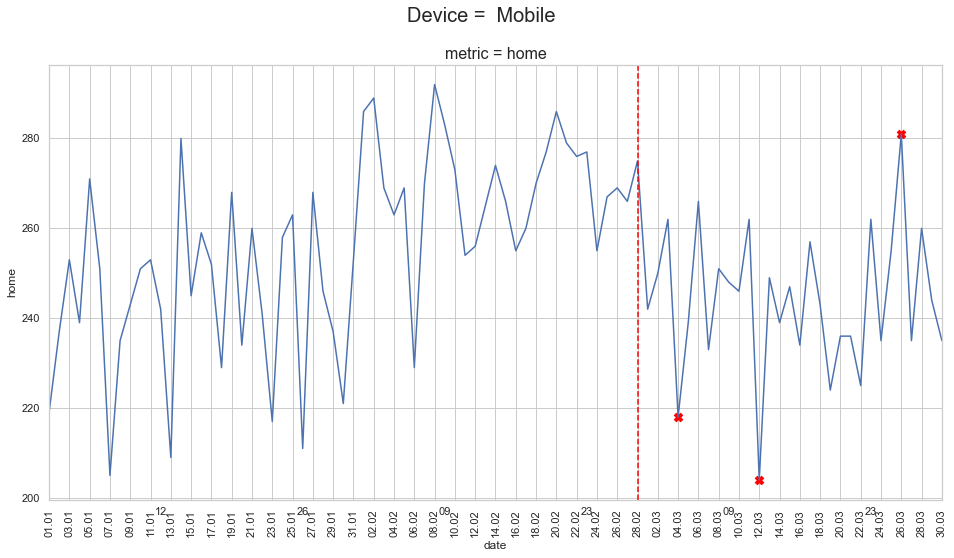

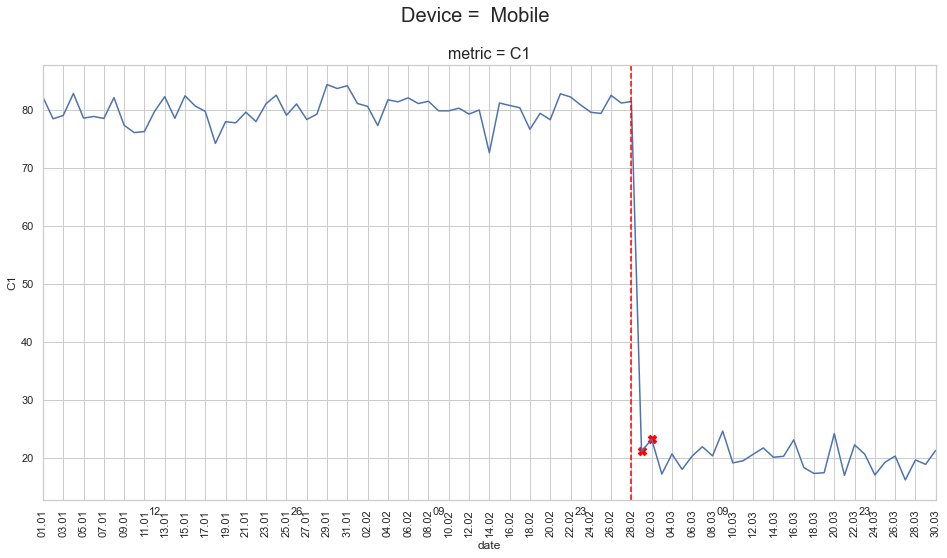

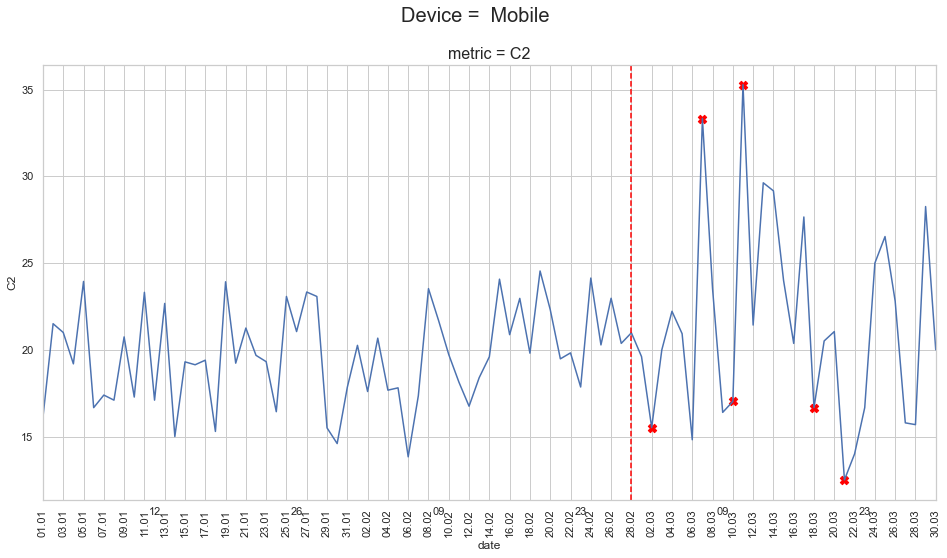

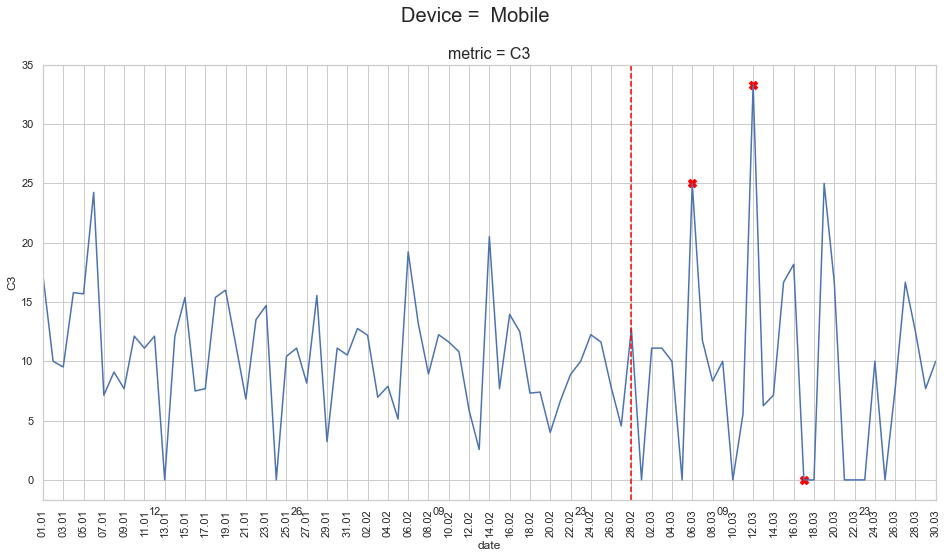

In [95]:
metrics = ['home','C1','C2','C3']

for metric in metrics:
    detection_anomaly(df=df_agg, device='Mobile',metric=metric, periods=30, cutoff='2015-02-28')

!!!!ALERT!!!! 01-03-2015 metric home= 480.00
!!!!ALERT!!!! 30-03-2015 metric home= 542.00
!!!!ALERT!!!! 29-03-2015 metric C1= 45.02
!!!!ALERT!!!! 01-03-2015 metric C2= 3.88
!!!!ALERT!!!! 02-03-2015 metric C2= 3.51
!!!!ALERT!!!! 02-03-2015 metric C3= 12.50
!!!!ALERT!!!! 03-03-2015 metric C3= 28.57
!!!!ALERT!!!! 05-03-2015 metric C3= 0.00
!!!!ALERT!!!! 07-03-2015 metric C3= 0.00


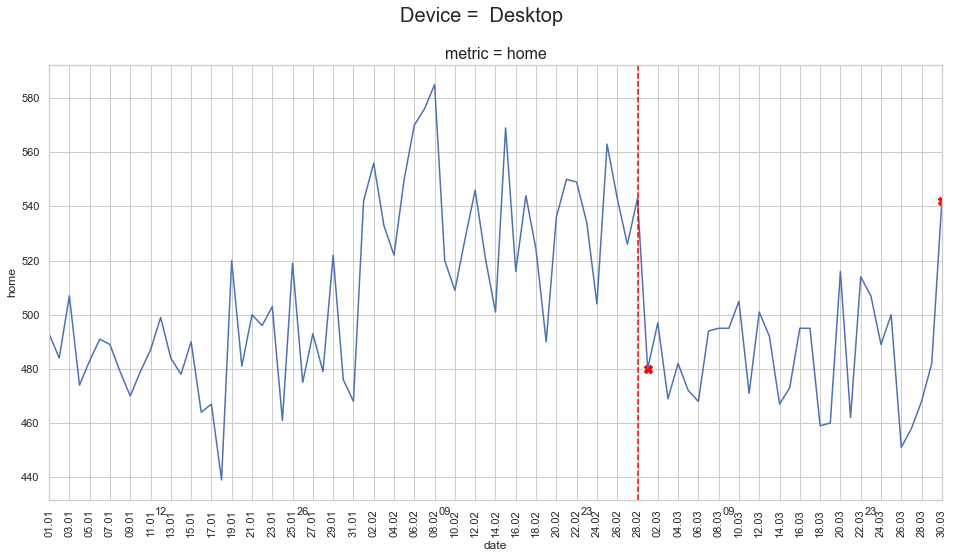

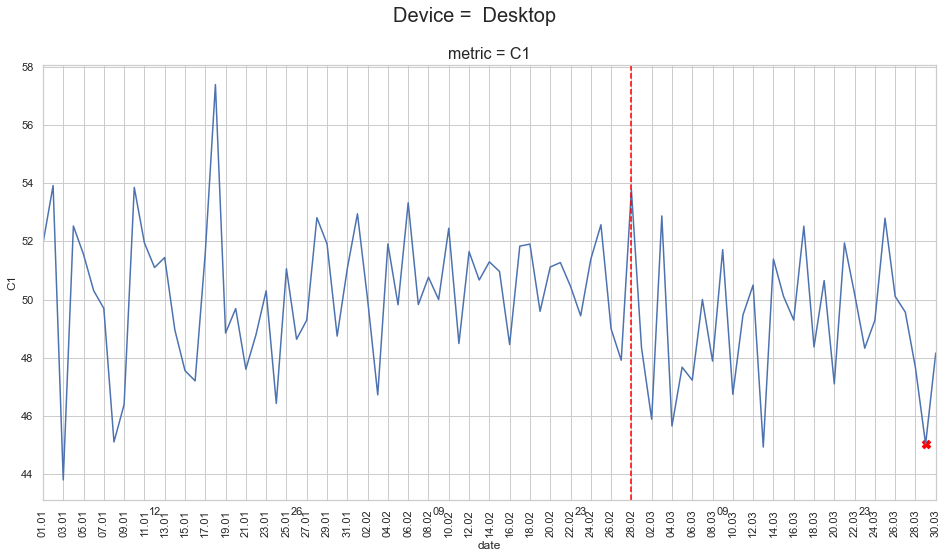

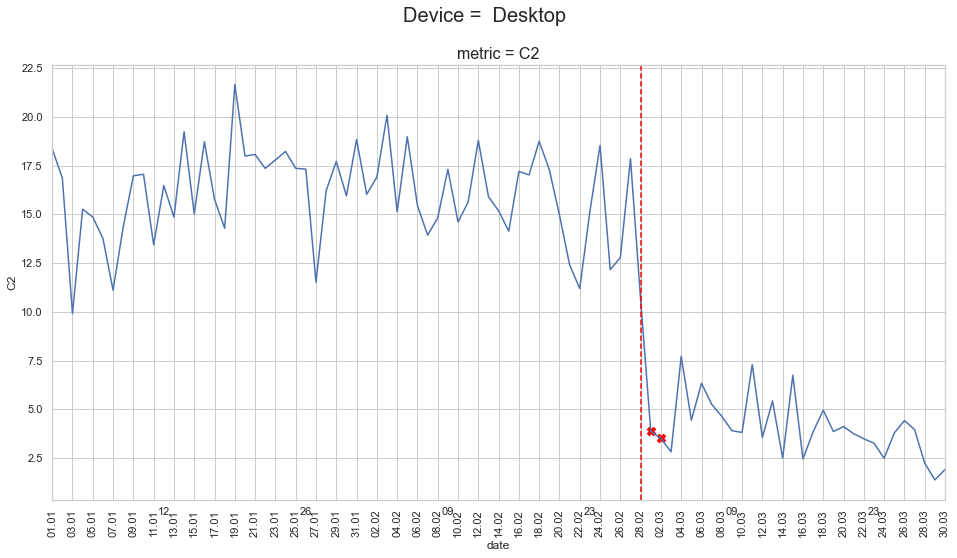

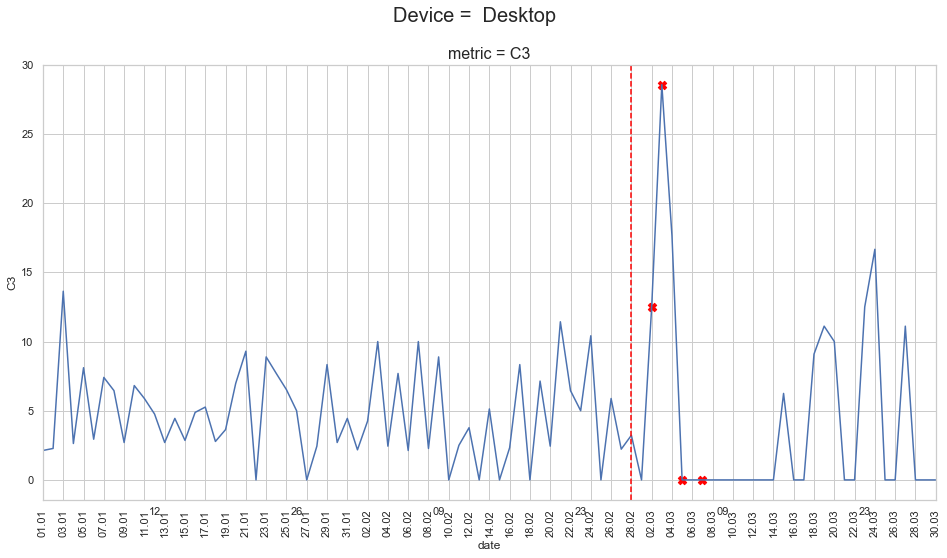

In [96]:
for metric in metrics:
    detection_anomaly(df=df_agg, device='Desktop',metric=metric, periods=30, cutoff='2015-02-28')

In general, this approach works quite well, in this artificial situation it has postponed almost all critical anomalies, there are also few false positives. It is convenient that the cutoff threshold from below and from above can be adjusted separately, which is done in this example. That is, the fall in the number of customers is more critical than its growth.

The method is adaptive, since the detected anomalies are not removed from the data set and contribute to the calculation of the error. But this is a minus, a return to the previous level after a long drawdown will also be detected as anomalies, or after a series of anomalies, the range of "normal data" is expanded, which increases the chance of missing the next anomaly.

This series has a clear weekly seasonality. In the future, seasonal models can be applied, for example  SARIMA or Holt-Winter